In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable

In [2]:
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_data = mnist_dataset.train_data.type(torch.float).reshape(-1, 1, 28, 28)
test_data = mnist_dataset.test_data.type(torch.float).reshape(-1, 1, 28, 28)
train_labels = mnist_dataset.train_labels
test_labels = mnist_dataset.test_labels

train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 =  nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.BatchNorm2d(4),
            nn.ReLU())
        
        self.layer2 =  nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer3 =  nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),   
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.Tensor(x)
        x = self.layer1(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.layer2(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.layer3(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.flatten(1)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


cnn = CNN()
it = iter(train_loader)
batch = next(it)[0]
print(cnn.forward(batch).shape)

torch.Size([32, 10])


In [5]:
def fit(model, train_loader):
    # ,lr=0.001, betas=(0.9,0.999))
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    BATCH_SIZE = 32
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == var_y_batch).sum()
            # print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
                

In [11]:
def evaluate(model):
    BATCH_SIZE=32
    correct = 0 
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))


In [12]:
fit(cnn, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 0.476801	 Accuracy:84.375%
Epoch : 0 [1600/60000 (3%)]	Loss: 0.247792	 Accuracy:80.637%
Epoch : 0 [3200/60000 (5%)]	Loss: 0.533741	 Accuracy:81.838%
Epoch : 0 [4800/60000 (8%)]	Loss: 0.338240	 Accuracy:83.009%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.597854	 Accuracy:84.080%
Epoch : 0 [8000/60000 (13%)]	Loss: 0.415205	 Accuracy:84.487%
Epoch : 0 [9600/60000 (16%)]	Loss: 0.477441	 Accuracy:85.154%
Epoch : 0 [11200/60000 (19%)]	Loss: 0.305850	 Accuracy:85.773%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.255789	 Accuracy:86.058%
Epoch : 0 [14400/60000 (24%)]	Loss: 0.335825	 Accuracy:86.495%
Epoch : 0 [16000/60000 (27%)]	Loss: 0.168144	 Accuracy:86.839%
Epoch : 0 [17600/60000 (29%)]	Loss: 0.082405	 Accuracy:87.228%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.283139	 Accuracy:87.391%
Epoch : 0 [20800/60000 (35%)]	Loss: 0.242442	 Accuracy:87.750%
Epoch : 0 [22400/60000 (37%)]	Loss: 0.244359	 Accuracy:88.004%
Epoch : 0 [24000/60000 (40%)]	Loss: 0.185612	 Accuracy:88.261%
Epoch 

KeyboardInterrupt: 

In [ ]:
evaluate(cnn)

Test accuracy:0.967% 


In [ ]:
! python -m pip install git+https://github.com/aimclub/eXplain-NNs.git

^C


In [8]:
def get_patches(x, kernel=3, strides=1): # from scratch
    patches = []
    input_dimension = x.shape[1] # input dimension
    # convolve each filter over the x, moving it vertically first and then horizontally
    tmp_y = out_y = 0                               
    while tmp_y + kernel <= input_dimension:
        tmp_x = out_x = 0
        while tmp_x + kernel <= input_dimension:
            patch = x[:, tmp_y:tmp_y + kernel, tmp_x:tmp_x + kernel]
            patches.append(patch)
            tmp_x += strides
            out_x += 1
        tmp_y += strides
        out_y += 1
    return patches

In [9]:
batch = next(iter(test_loader))[0]

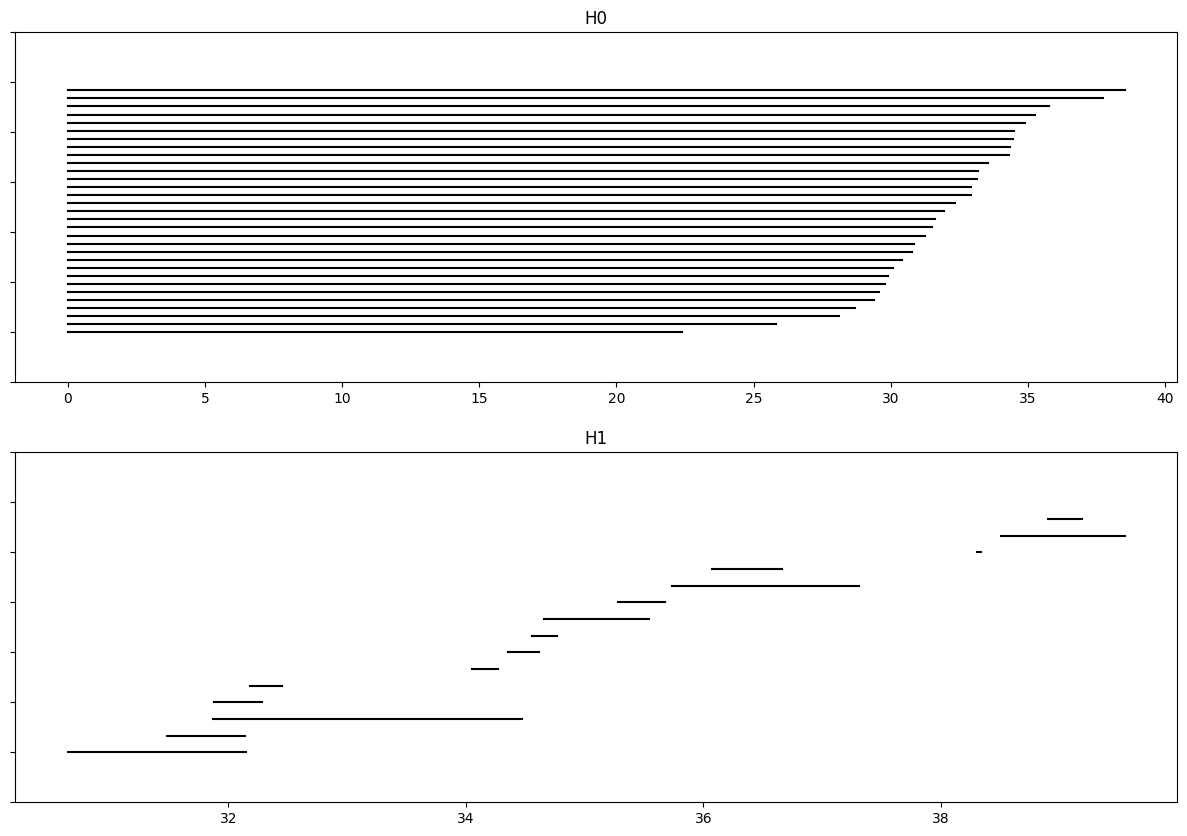

In [10]:
import eXNN.topology as topology
barcodes = topology.get_nn_barcodes(cnn, batch, layers=['layer1'],
                         hom_type = "standard", 
                         coefs_type = "2")
topology.plot_barcode(barcodes['layer1'])


In [17]:
import eXNN
bar = eXNN.topology.get_data_barcode(torch.randn(100, 25), "standard", "2")
topology.plot_barcode(bar)

In [19]:
def display():
    bar = eXNN.topology.get_data_barcode(torch.randn(100, 25), "standard", "2")
    topology.plot_barcode(bar)
    bar1 = eXNN.topology.get_data_barcode(torch.randn(100, 25), "standard", "2")
    topology.plot_barcode(bar1)
    bar2 = eXNN.topology.get_data_barcode(torch.randn(100, 25), "standard", "2")
    topology.plot_barcode(bar2)
    
display()

In [ ]:
import matplotlib.pyplot as plt 

plt.

In [13]:
topology.evaluate_barcode(barcodes['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 42.3530158996582,
 'mean_length': 35.24777006333874,
 'median_length': 35.358375549316406,
 'stdev_length': 3.413884671731371,
 'sum_length': 1092.680871963501,
 'ratio_2_1': 1.5200344199600675,
 'ratio_3_1': 1.5155093795853374,
 'h': 3.4291818215468597,
 'normh': 0.4901359244933578,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 35.24777006333874,
 'stdev_death': 3.413884671731371}

In [23]:
def get_num_barcodes(digit:int, layers, max_size=32):
    data = mnist_dataset.test_data.type(torch.float).reshape(-1, 1, 28, 28)
    labels = mnist_dataset.test_labels
    digit_imgs = data[labels == digit][:max_size]
    digit_barcodes = topology.get_nn_barcodes(cnn, digit_imgs, layers=layers,
                         hom_type = "standard", 
                         coefs_type = "2")
    return digit_barcodes

In [24]:
def get_num_dataset(digit=None, max_size=32, zero_id=0):
    data = mnist_dataset.test_data.type(torch.float).reshape(-1, 1, 28, 28)
    labels = mnist_dataset.test_labels
    if digit:
        digit_imgs = data[labels == digit][zero_id:zero_id + max_size]
    else:
        digit_imgs = data[zero_id:zero_id + max_size]
    return digit_imgs

## Barcodes for digits

### 0

#### layer 1

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



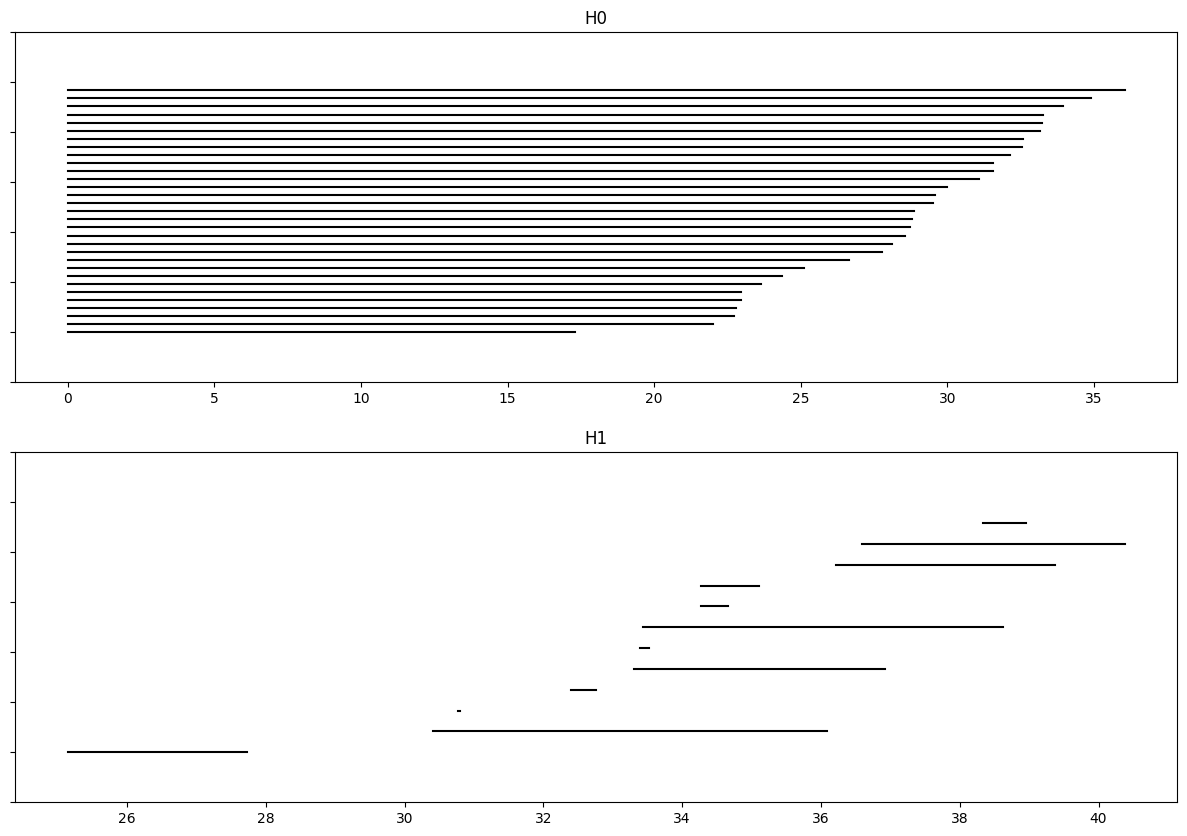

In [24]:
topology.plot_barcode(get_num_barcodes(0, ['layer1'])['layer1'])

In [73]:
topology.evaluate_barcode(get_num_barcodes(0, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 36.04439163208008,
 'mean_length': 28.595428282214748,
 'median_length': 28.86028480529785,
 'stdev_length': 4.478072649226402,
 'sum_length': 886.4582767486572,
 'ratio_2_1': 2.017786151742771,
 'ratio_3_1': 1.962267557440212,
 'h': 3.421263284755378,
 'normh': 0.5040732726885986,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 28.595428282214748,
 'stdev_death': 4.478072649226402}

#### layer 2

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



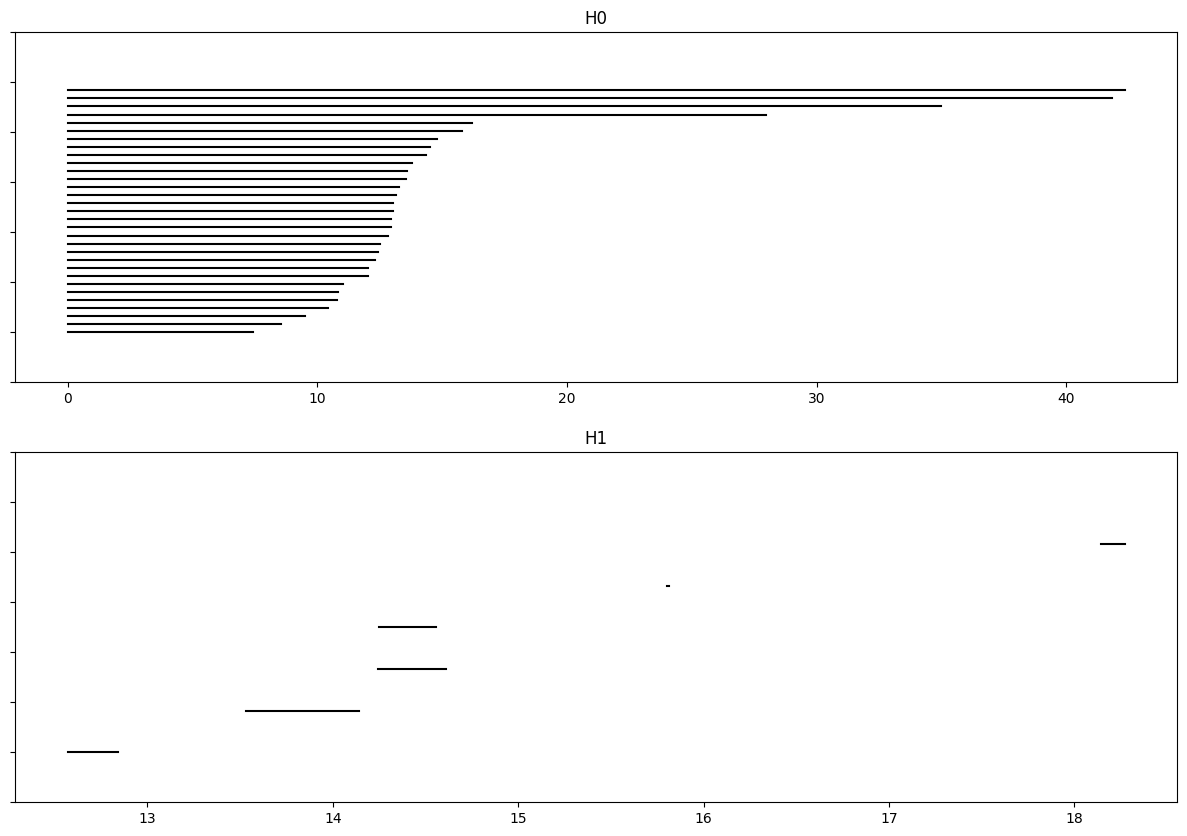

In [46]:
topology.plot_barcode(get_num_barcodes(1, ['layer2'])['layer2'])

In [71]:
topology.evaluate_barcode(get_num_barcodes(0, ['layer2'])['layer2'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 23.108720779418945,
 'mean_length': 17.151204078428208,
 'median_length': 17.81133270263672,
 'stdev_length': 3.1923501997208525,
 'sum_length': 531.6873264312744,
 'ratio_2_1': 2.3808463263006514,
 'ratio_3_1': 2.262363250251162,
 'h': 3.416054491116958,
 'normh': 0.544299591557057,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 17.151204078428208,
 'stdev_death': 3.1923501997208525}

#### layer 3

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



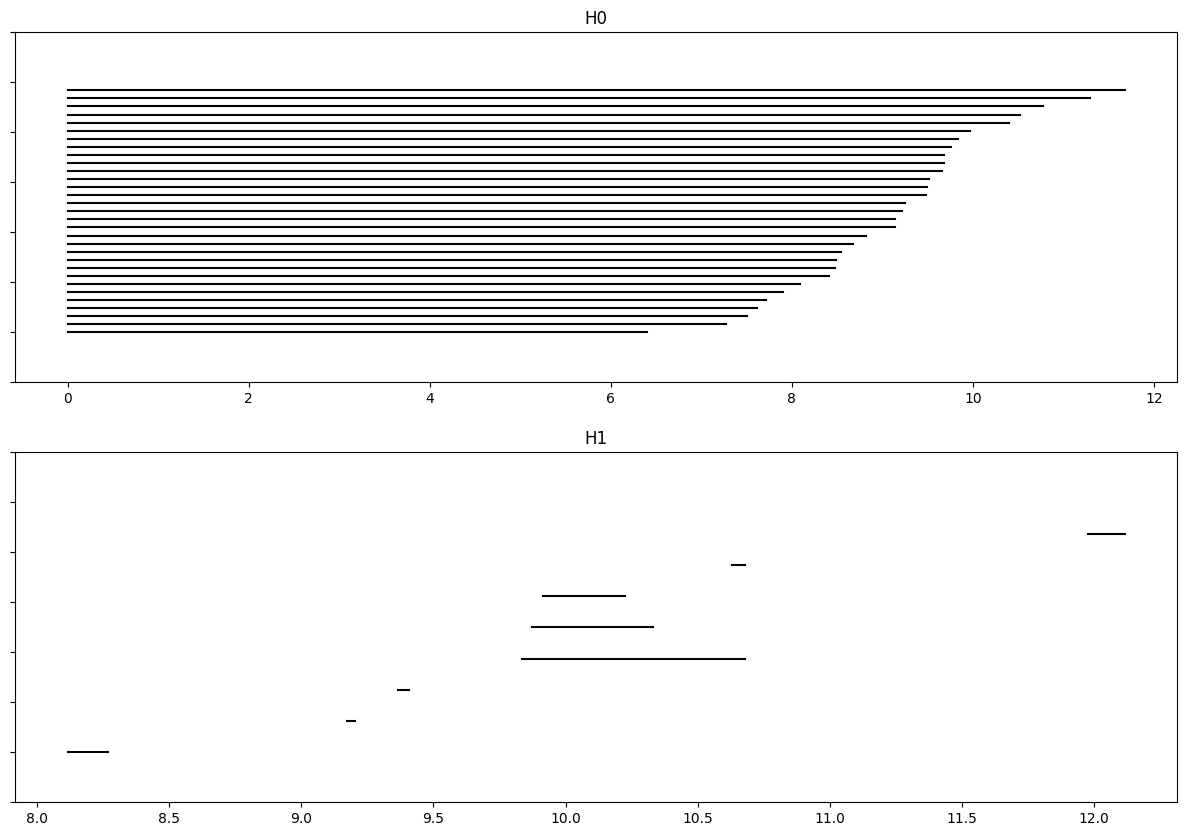

In [74]:
topology.plot_barcode(get_num_barcodes(0, ['layer3'])['layer3'])

In [75]:
topology.evaluate_barcode(get_num_barcodes(0, ['layer3'])['layer3'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 11.472249031066895,
 'mean_length': 8.981938515940021,
 'median_length': 9.19404411315918,
 'stdev_length': 1.2343937239917673,
 'sum_length': 278.4400939941406,
 'ratio_2_1': 1.593449522622832,
 'ratio_3_1': 1.553410402367095,
 'h': 3.424418054776194,
 'normh': 0.6083308942673333,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 8.981938515940021,
 'stdev_death': 1.2343937239917673}

### 1

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



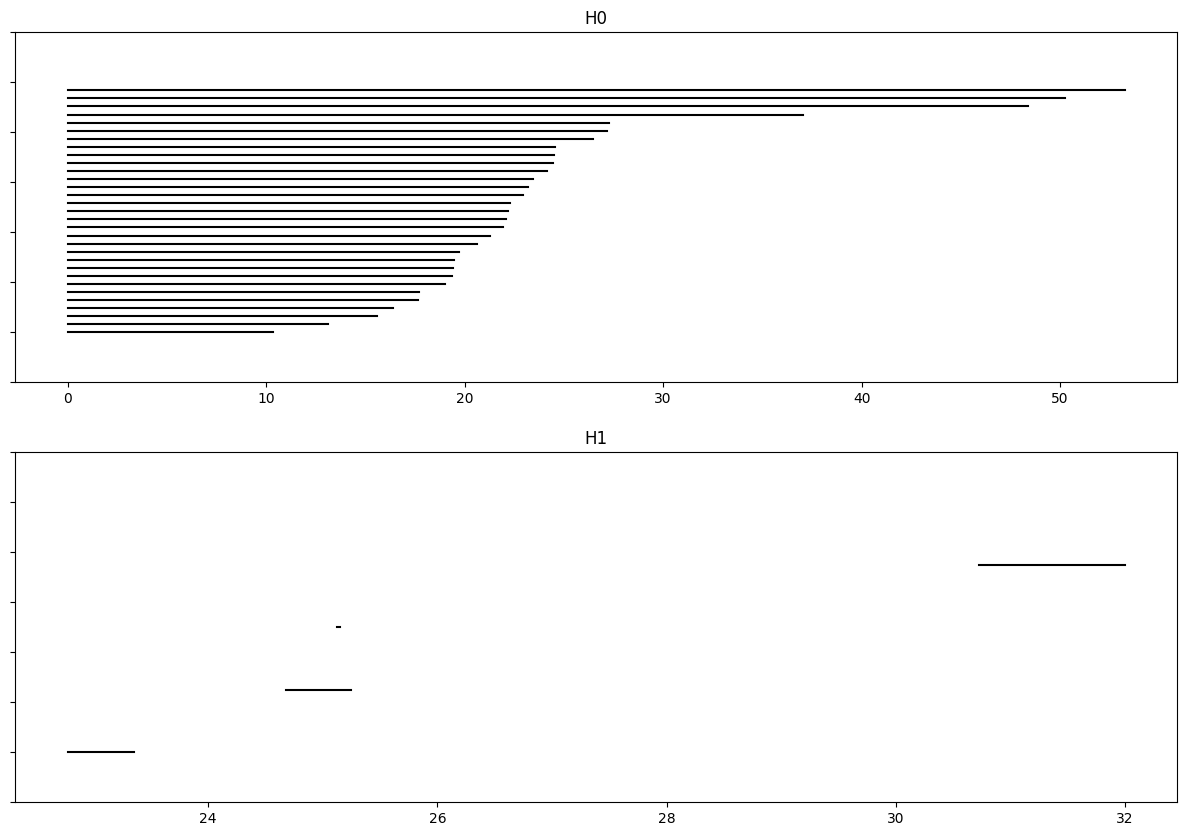

In [25]:
topology.plot_barcode(get_num_barcodes(1, ['layer1'])['layer1'])

In [ ]:
topology.evaluate_barcode(get_num_barcodes(1, ['layer1'])['layer1'])

### 2

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



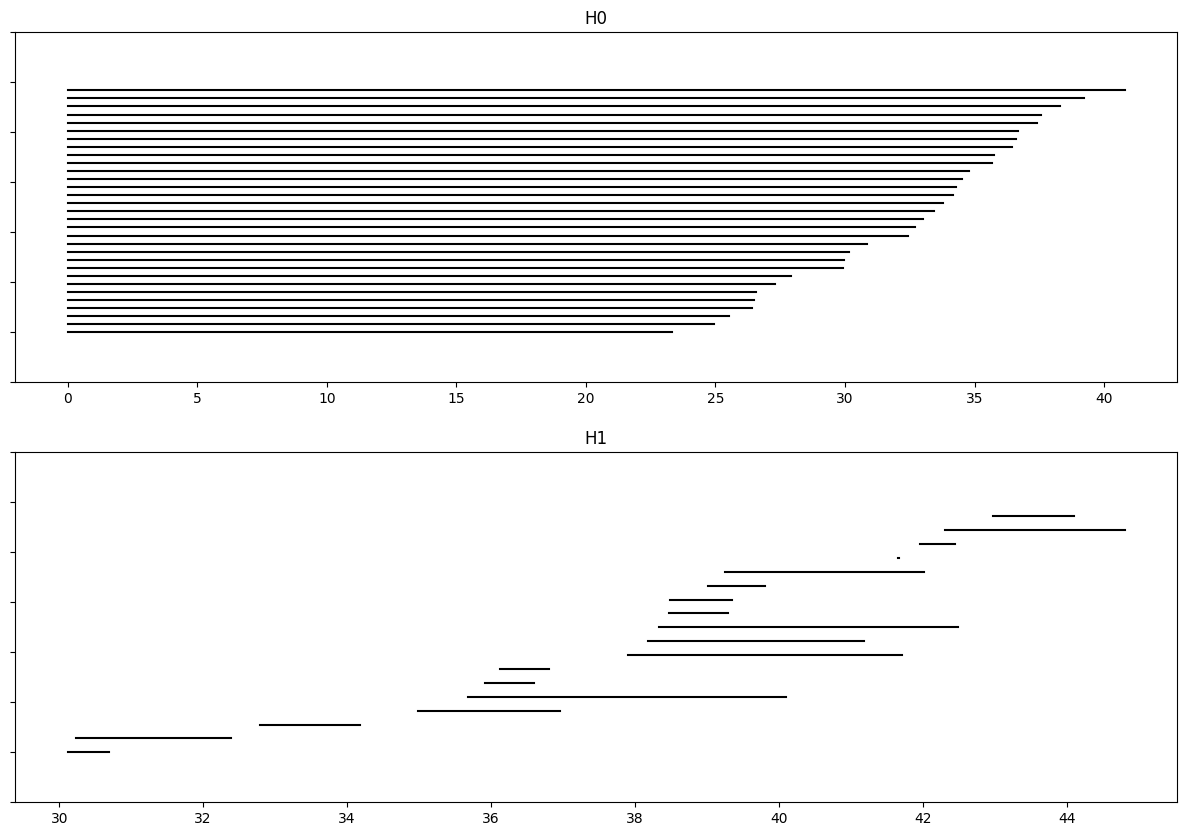

In [26]:
topology.plot_barcode(get_num_barcodes(2, ['layer1'])['layer1'])

In [33]:
topology.evaluate_barcode(get_num_barcodes(2, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 40.78804016113281,
 'mean_length': 32.480355785739036,
 'median_length': 33.44585037231445,
 'stdev_length': 4.58843427918549,
 'sum_length': 1006.8910293579102,
 'ratio_2_1': 1.6810038129980927,
 'ratio_3_1': 1.6413992036647016,
 'h': 3.4238086927497515,
 'normh': 0.49515481238995984,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 32.480355785739036,
 'stdev_death': 4.58843427918549}

### 3

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



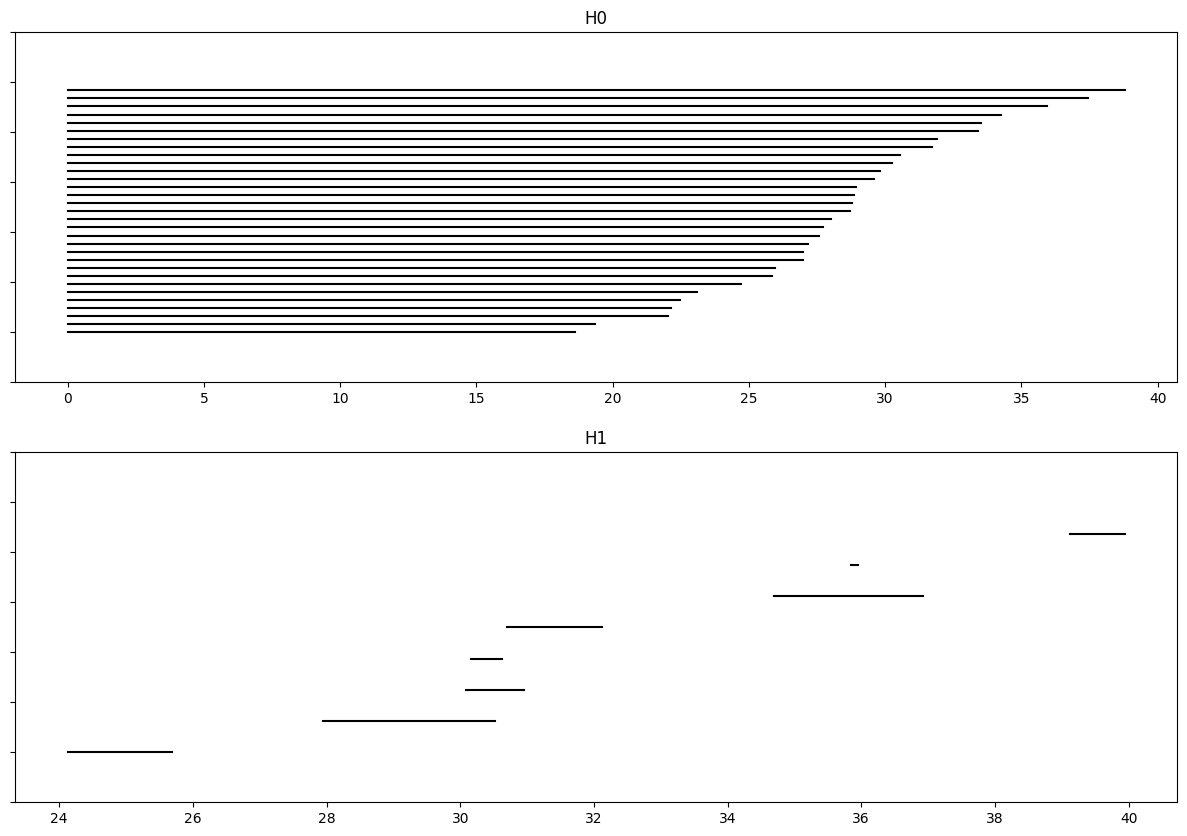

In [27]:
topology.plot_barcode(get_num_barcodes(3, ['layer1'])['layer1'])

In [34]:
topology.evaluate_barcode(get_num_barcodes(3, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 38.785606384277344,
 'mean_length': 28.42282578252977,
 'median_length': 28.69379234313965,
 'stdev_length': 4.82172442846916,
 'sum_length': 881.1075992584229,
 'ratio_2_1': 2.011597282812235,
 'ratio_3_1': 1.9307700150266078,
 'h': 3.419445144467981,
 'normh': 0.5042551989089401,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 28.42282578252977,
 'stdev_death': 4.82172442846916}

### 4

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



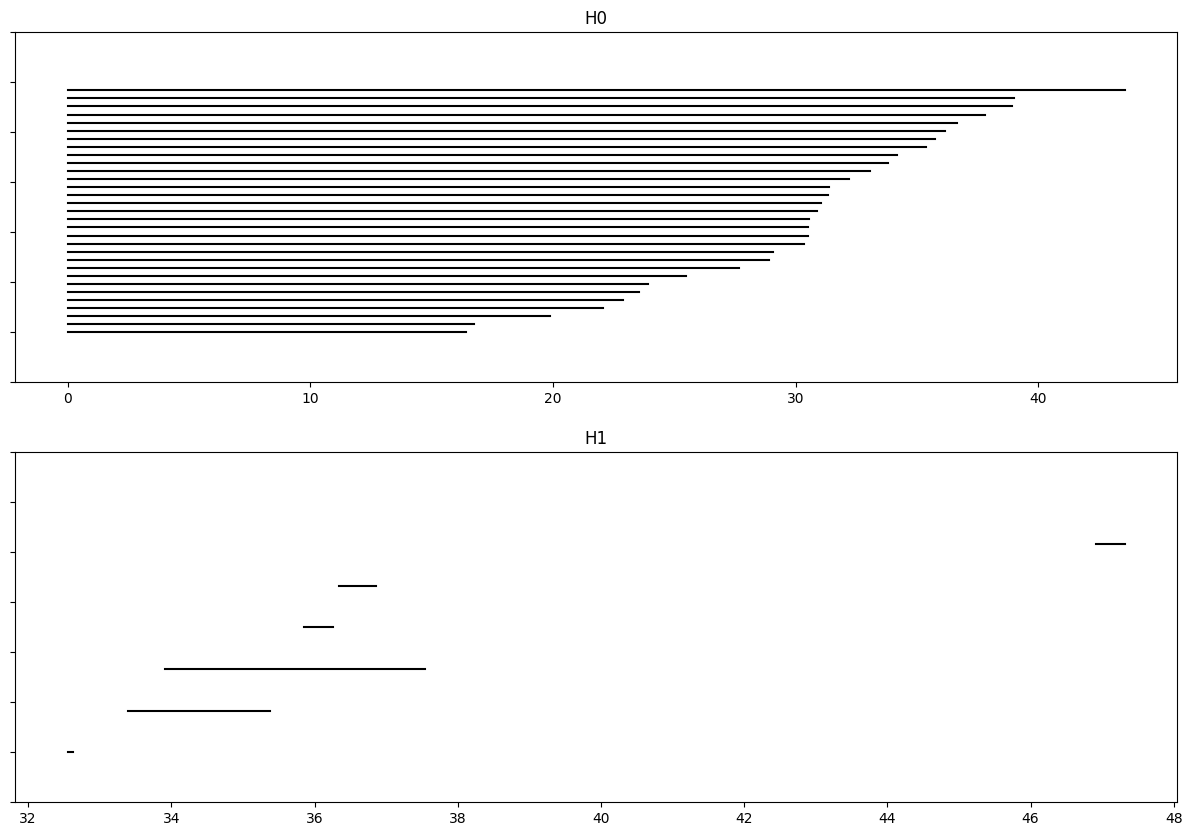

In [28]:
topology.plot_barcode(get_num_barcodes(4, ['layer1'])['layer1'])

In [35]:
topology.evaluate_barcode(get_num_barcodes(4, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 43.54707717895508,
 'mean_length': 30.303941295992942,
 'median_length': 30.893526077270508,
 'stdev_length': 6.430730225329746,
 'sum_length': 939.4221801757812,
 'ratio_2_1': 2.3747352957300727,
 'ratio_3_1': 2.369924623745936,
 'h': 3.41033907023149,
 'normh': 0.49820409846002706,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 30.303941295992942,
 'stdev_death': 6.430730225329746}

### 5

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



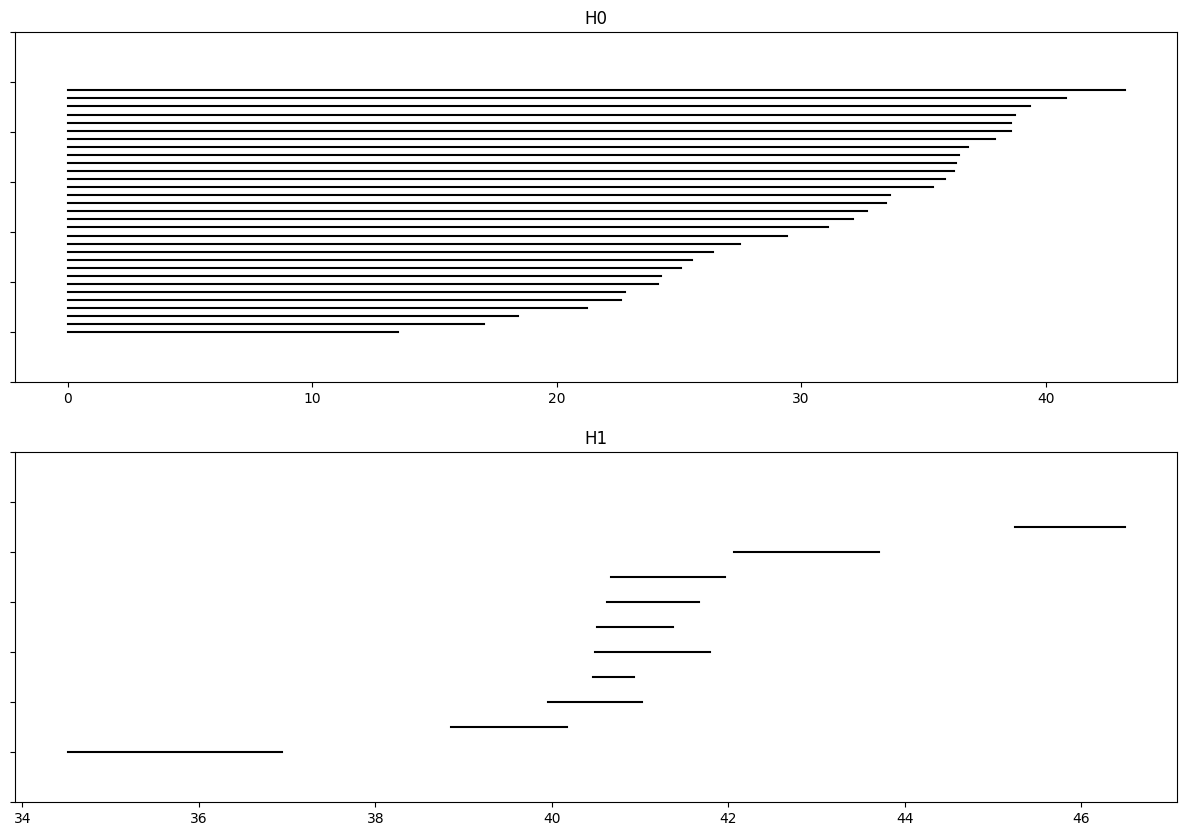

In [29]:
topology.plot_barcode(get_num_barcodes(5, ['layer1'])['layer1'])

In [36]:
topology.evaluate_barcode(get_num_barcodes(5, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 43.22623062133789,
 'mean_length': 30.822213295967348,
 'median_length': 32.68294143676758,
 'stdev_length': 7.629076866911743,
 'sum_length': 955.4886121749878,
 'ratio_2_1': 3.02485895773421,
 'ratio_3_1': 2.917336734182599,
 'h': 3.401290367666072,
 'normh': 0.49565431555951917,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 30.822213295967348,
 'stdev_death': 7.629076866911743}

### 6

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



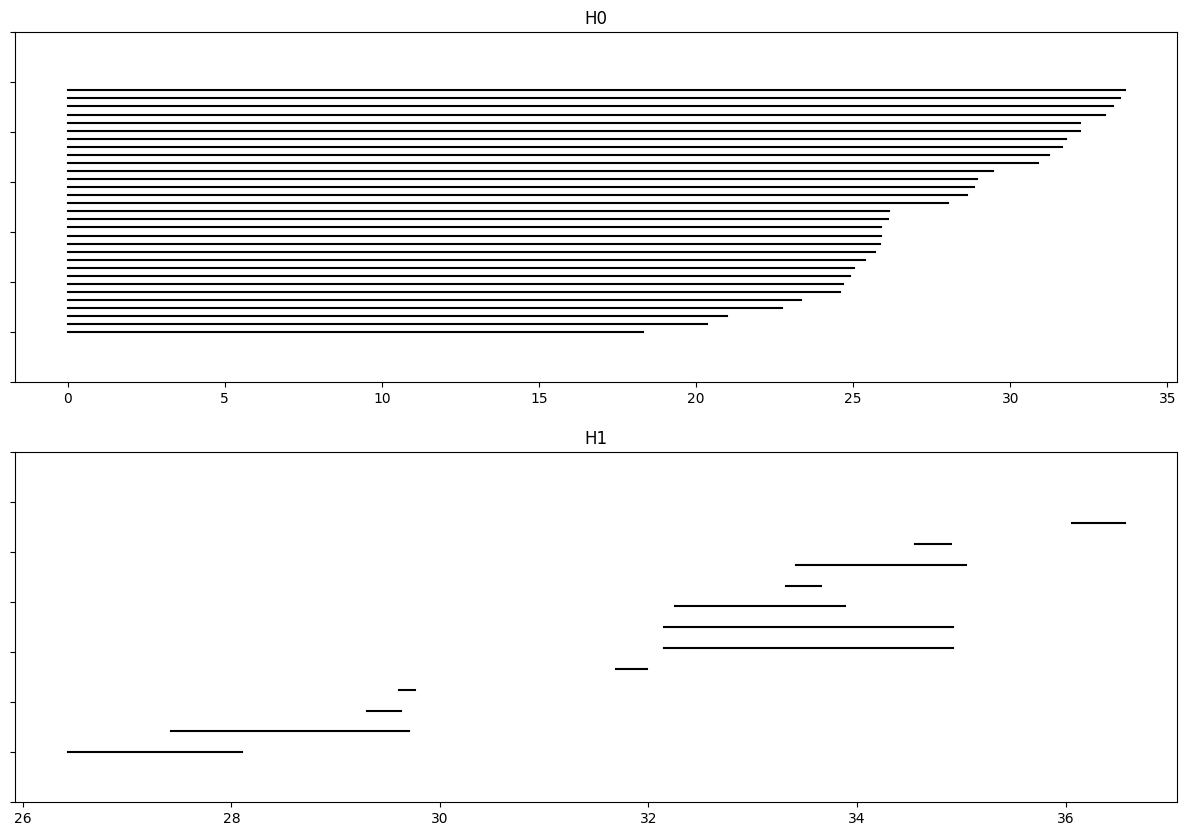

In [38]:
topology.plot_barcode(get_num_barcodes(6, ['layer1'])['layer1'])

In [39]:
topology.evaluate_barcode(get_num_barcodes(6, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 33.633365631103516,
 'mean_length': 27.516735261486424,
 'median_length': 26.122669219970703,
 'stdev_length': 4.0909031141337655,
 'sum_length': 853.0187931060791,
 'ratio_2_1': 1.8287871644448705,
 'ratio_3_1': 1.8171318902467932,
 'h': 3.422713805269823,
 'normh': 0.5071602577725783,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 27.516735261486424,
 'stdev_death': 4.0909031141337655}

### 7

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



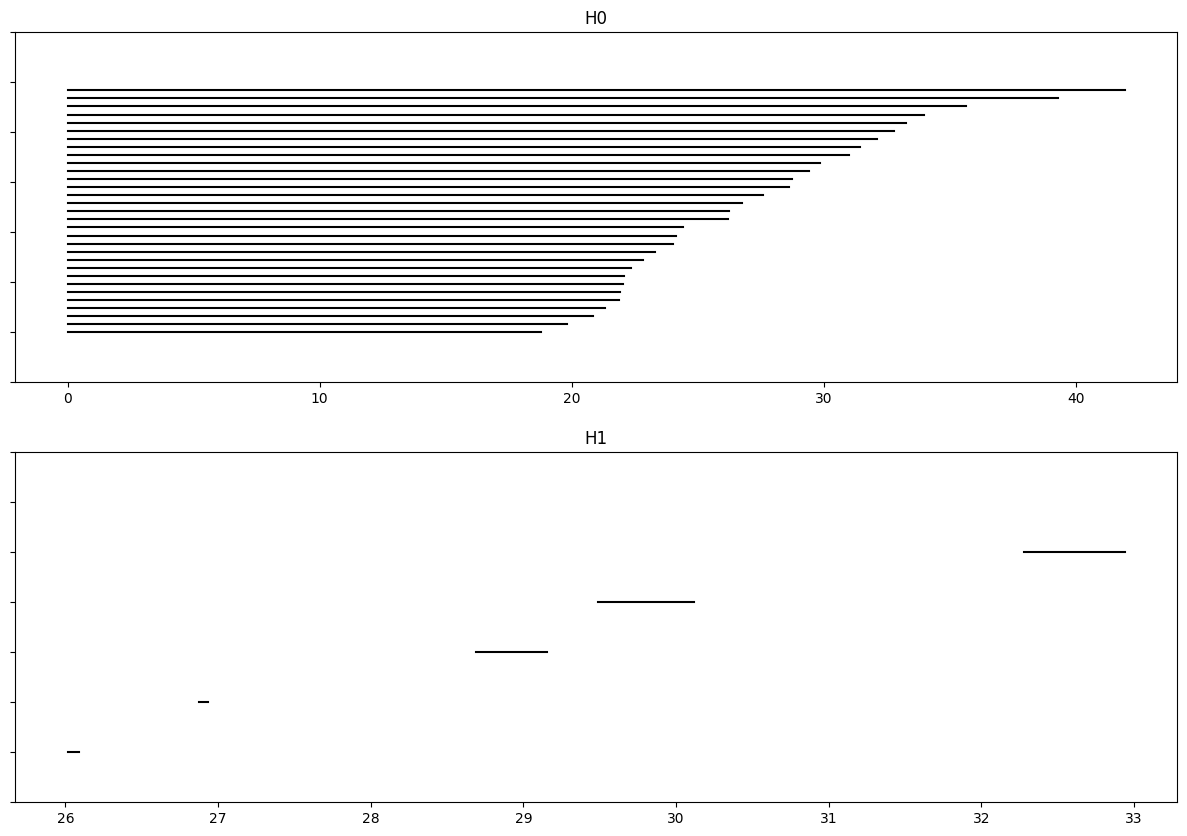

In [40]:
topology.plot_barcode(get_num_barcodes(7, ['layer1'])['layer1'])

In [41]:
topology.evaluate_barcode(get_num_barcodes(7, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 41.93821716308594,
 'mean_length': 27.244118413617535,
 'median_length': 26.236976623535156,
 'stdev_length': 5.733324009828741,
 'sum_length': 844.5676708221436,
 'ratio_2_1': 2.0942272714428394,
 'ratio_3_1': 1.8991496923283655,
 'h': 3.412531609931018,
 'normh': 0.5063986197396004,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 27.244118413617535,
 'stdev_death': 5.733324009828741}

### 8

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



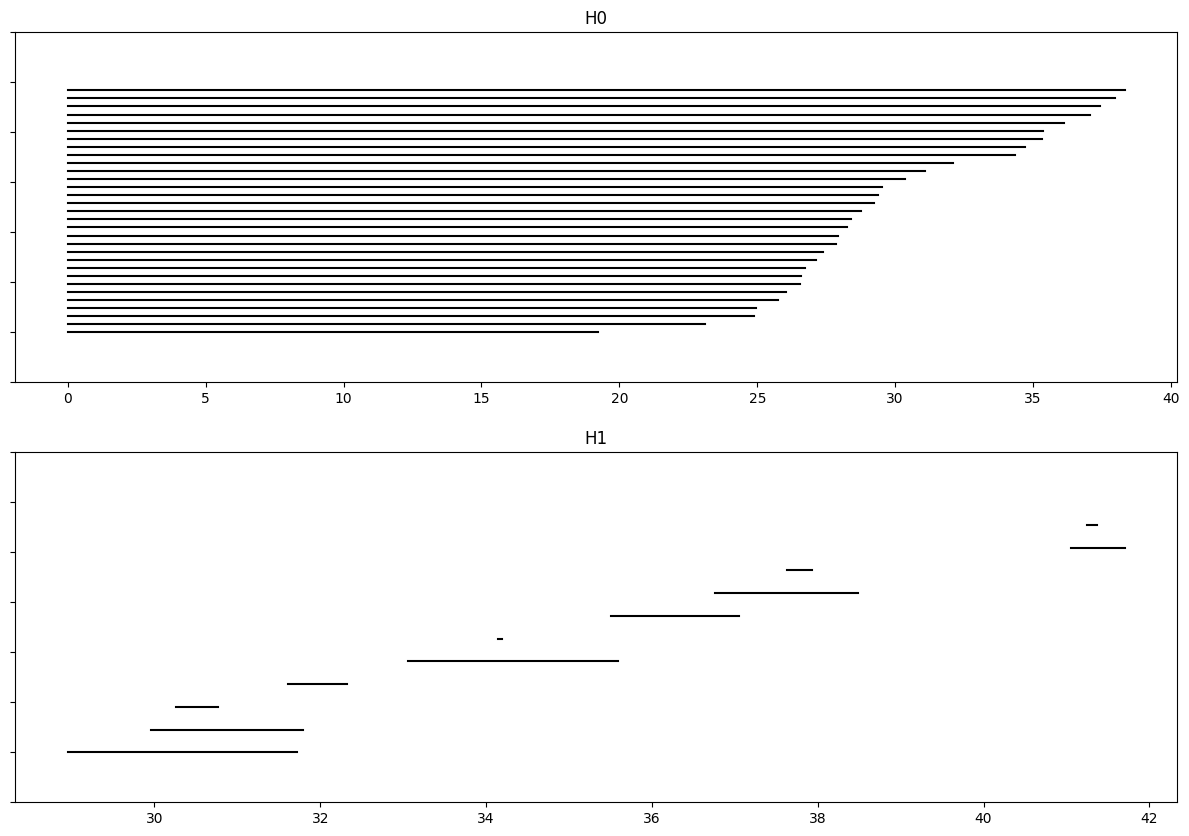

In [42]:
topology.plot_barcode(get_num_barcodes(8, ['layer1'])['layer1'])

In [43]:
topology.evaluate_barcode(get_num_barcodes(8, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 38.31441116333008,
 'mean_length': 29.931511725148848,
 'median_length': 28.76360511779785,
 'stdev_length': 4.732796710470368,
 'sum_length': 927.8768634796143,
 'ratio_2_1': 1.9742576739485185,
 'ratio_3_1': 1.9465685492859754,
 'h': 3.4214684782670006,
 'normh': 0.5007345288374857,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 29.931511725148848,
 'stdev_death': 4.732796710470368}

### 9

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



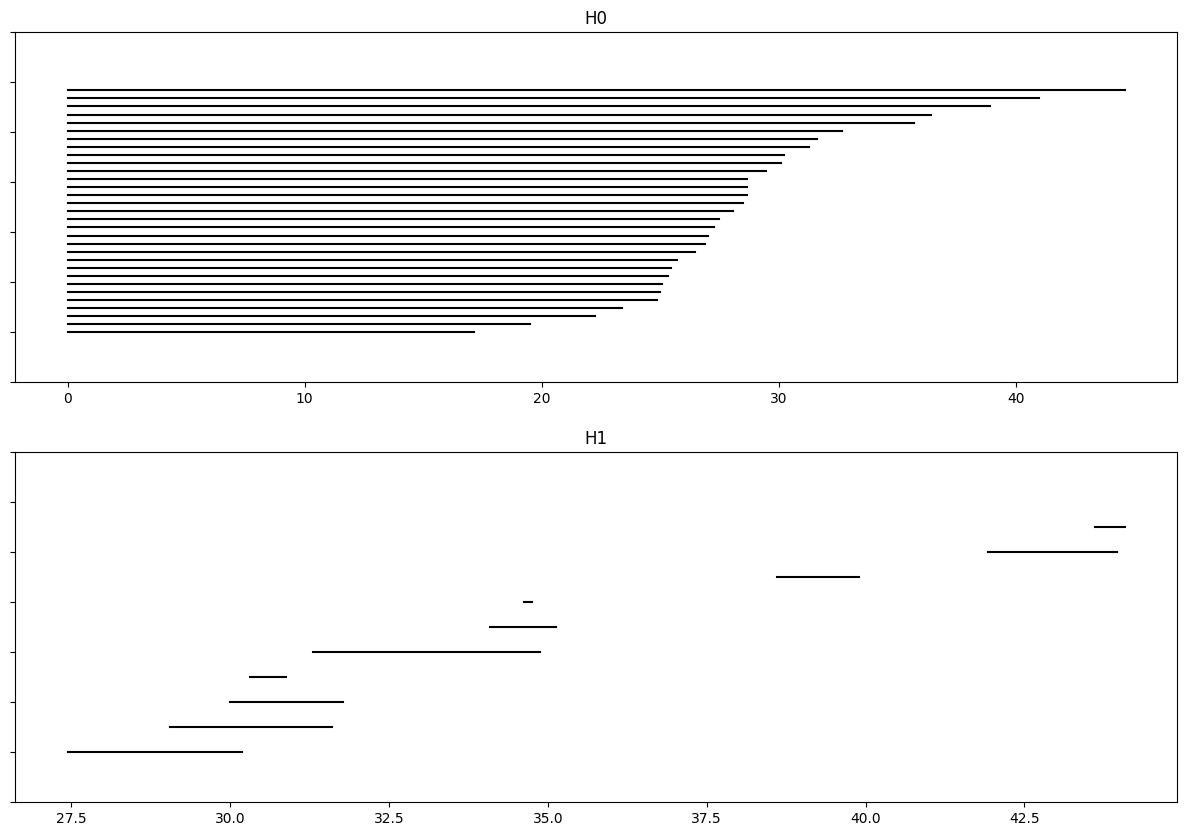

In [44]:
topology.plot_barcode(get_num_barcodes(9, ['layer1'])['layer1'])

In [45]:
topology.evaluate_barcode(get_num_barcodes(9, ['layer1'])['layer1'])

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\eXNN\topology\metrics.py:128: RuntimeWarning:

divide by zero encountered in double_scalars



{'max_length': 44.58473587036133,
 'mean_length': 28.815449806951708,
 'median_length': 28.050321578979492,
 'stdev_length': 5.758506116884481,
 'sum_length': 893.2789440155029,
 'ratio_2_1': 2.3919220207349925,
 'ratio_3_1': 2.271540745528602,
 'h': 3.414563908074014,
 'normh': 0.5025187215612862,
 'snr': inf,
 'mean_birth': 0.0,
 'stdev_birth': 0.0,
 'mean_death': 28.815449806951708,
 'stdev_death': 5.758506116884481}

## Barcodes for channels

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



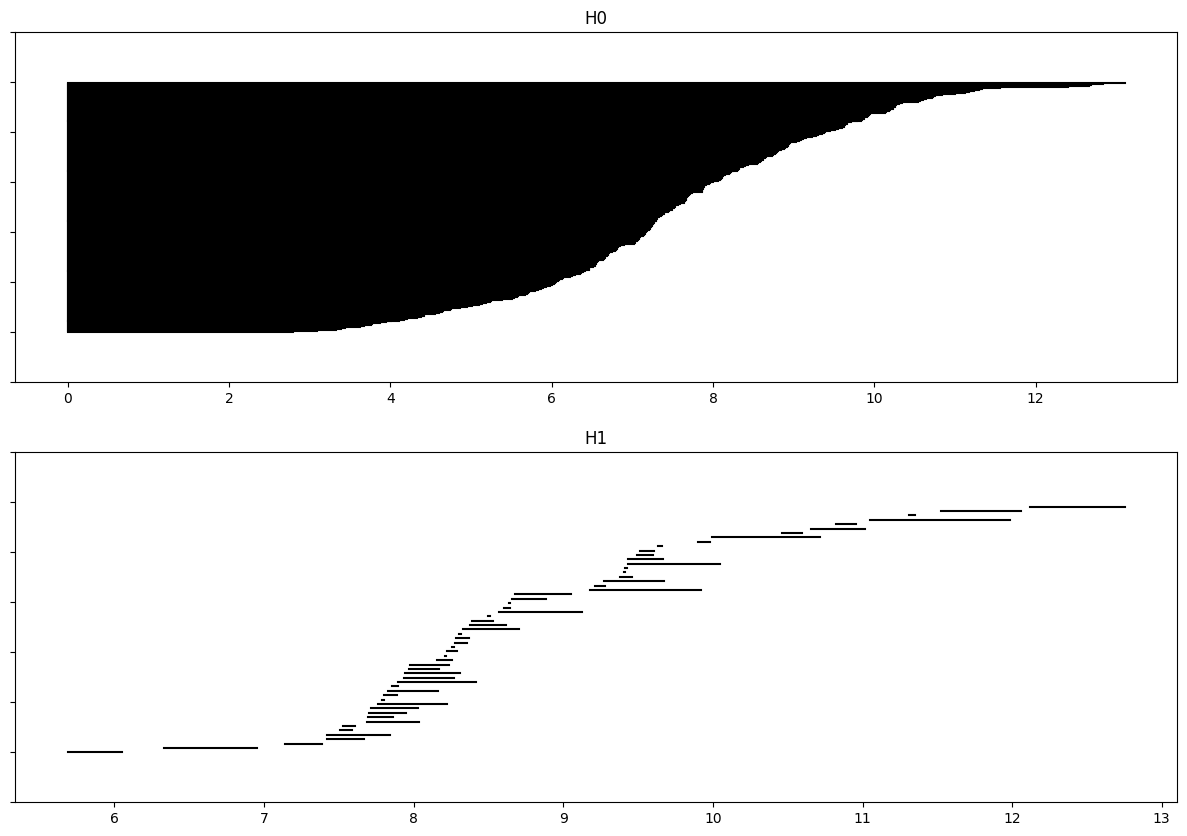

In [25]:
def get_channels_barcodes(channel_id, data, layer, model):
    act = topology.homologies._get_activation(model, data, layer)
    channels = act[:, channel_id:channel_id+1]
    barcode = topology.homologies.compute_data_barcode(channels, 'standard', '2')
    return barcode
    
topology.plot_barcode(get_channels_barcodes(1, get_num_dataset(max_size=256, zero_id=512), 'layer1', cnn))

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning:

test_data has been renamed data

c:\Users\kiril\Coding\VScode\.venv-tda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning:

test_labels has been renamed targets



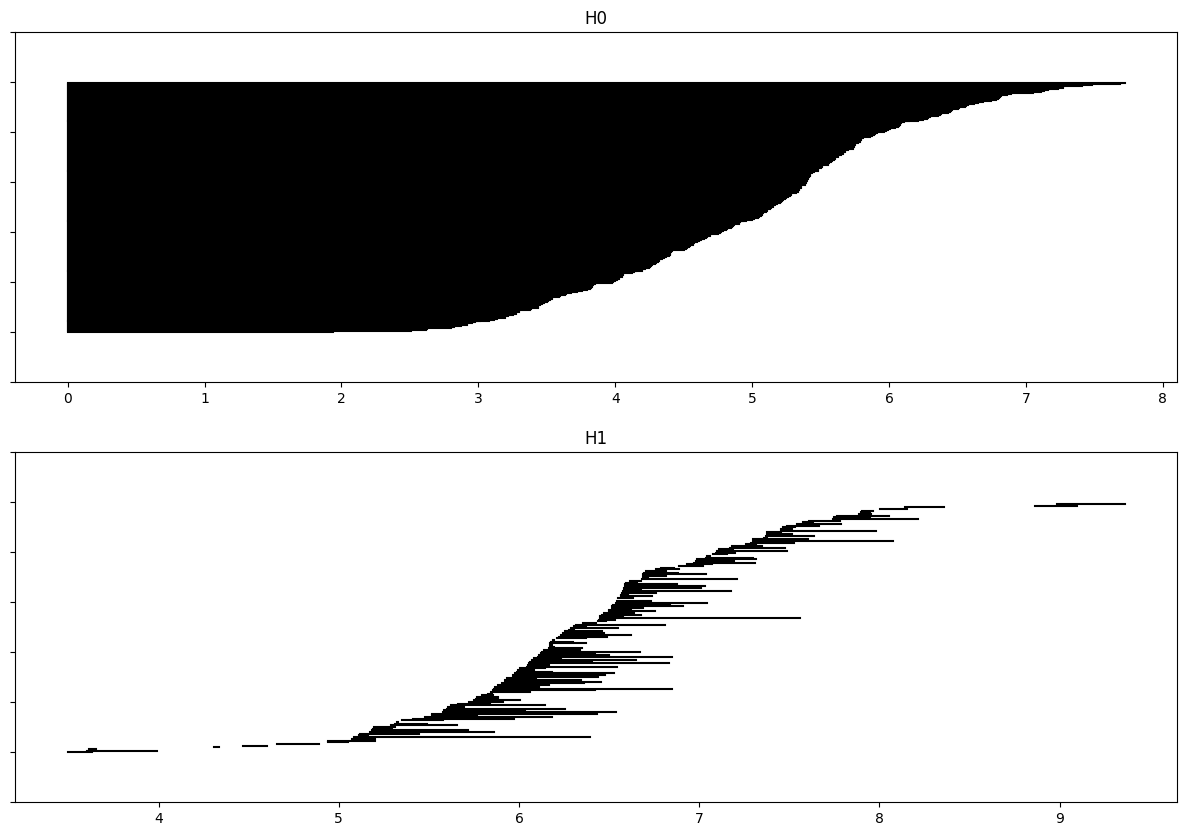

In [31]:
topology.plot_barcode(get_channels_barcodes(0, get_num_dataset(max_size=256, zero_id=512), 'layer1', cnn))